**LOADING LIBRARIES**

In [0]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, MaxPooling2D, Conv2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.misc

from scipy.optimize import fmin_l_bfgs_b

**IMAGE PROCESSING and SCALING**

In [0]:
# this is just a helper function to undo the preprocessing done by the vgg16's preprocess_input function, so that we can plot the image using matplotlib

def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  
  img = img[..., ::-1]
  return img

# Again a helper function to scale pixels of image, so that we can plot the image using matplotlib
def scale_img(x):
  x = x - x.min()
  x = x/x.max()
  return x

In [24]:
content_image_path = 'content.jpg'
content_shape = np.array(image.img_to_array(scipy.misc.imread(content_image_path))).shape
batch_shape = (1, content_shape[0], content_shape[1], content_shape[2])
shape = (content_shape[0], content_shape[1], content_shape[2])

style_image_path = 'style_3.jpg'
style_shape = np.array(image.img_to_array(scipy.misc.imread(style_image_path))).shape

print(content_shape)
print(style_shape)

(667, 1000, 3)
(667, 1000, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


**BUILDING THE VGG MODEL**

In [0]:
# function to replace all max pooling layers in vgg16 model to average pooling layers
# it is done because max pooling layers throw some of the data away while average pooling layers preserve it.

def VGG16_AvgPool(shape):
  vgg = VGG16(input_shape = shape, weights = 'imagenet', include_top = False)
  new_model = Sequential()
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      new_model.add(AveragePooling2D())
    else:
      new_model.add(layer)
      
  return new_model

In [0]:
#function ensures that there are num_convs number of convolutional layers in the network

def VGG16_AvgPool_Cutoff(shape, num_convs):
  if num_convs<1 or num_convs>13:
    print("num_convs must be in the range [1, 13]")
    return None
  
  model = VGG16_AvgPool(shape)
  new_model = Sequential()
  n = 0
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n+=1
    new_model.add(layer)
    
    if n>=num_convs:
      break
    
  return new_model

**FUNCTION TO GENERATE A NOISY CONTENT IMAGE**

In [0]:
def generate_noise_image(image,  image_shape, noise_ratio = 0.6):
    # Generate a random noise_image
    print(image_shape)
    noise_image = np.random.uniform(-20, 20, (1, image_shape[0], image_shape[1], image_shape[2])).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + image * (1 - noise_ratio)
    
    return input_image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(667, 1000, 3)


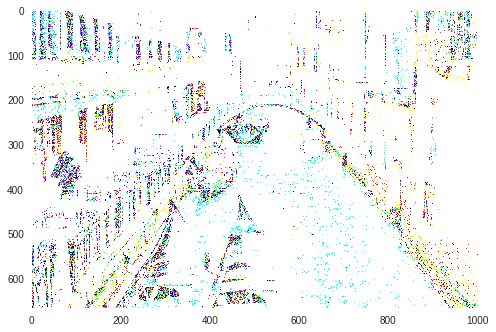

In [28]:
content_image = generate_noise_image(scipy.misc.imread(content_image_path), content_shape)[0]
plt.imshow(content_image)

**CODE TO RE-GENERATE CONTENT IMAGE FROM A RANDOMLY GENERATED IMAGE**

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step
iter = 0 loss = 41.07904815673828
iter = 1 loss = 18.190387725830078
iter = 2 loss = 11.152182579040527
iter = 3 loss = 7.873805046081543
iter = 4 loss = 6.204202175140381
iter = 5 loss = 6.072863578796387
iter = 6 loss = 6.0733184814453125
iter = 7 loss = 6.073713302612305
iter = 8 loss = 6.073713302612305
iter = 9 loss = 6.073713302612305
iter = 10 loss = 6.073713302612305
iter = 11 loss = 6.073713302612305
iter = 12 loss = 6.073713302612305
iter = 13 loss = 6.073713302612305
iter = 14 loss = 6.073713302612305
iter = 15 loss = 6.073713302612305
iter = 16 loss = 6.073713302612305
iter = 17 loss = 6.073713302612305
iter = 18 loss = 6.073713302612305
iter = 19 loss = 6.073713302612305
iter = 20 loss = 6.073713302612305
iter = 21 loss = 6.073713302612305
iter = 22 loss = 6.073713302612305
iter = 23 loss = 6.073713302612305
iter = 24 loss = 6.07371330261

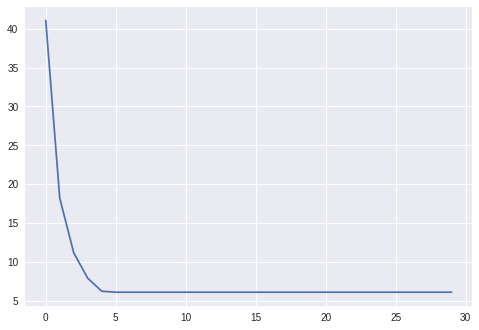

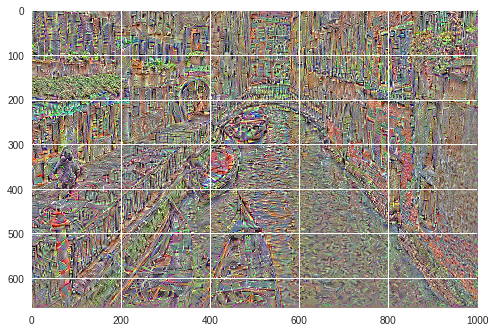

In [17]:
img = image.load_img(content_image_path)
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

# making a content model
content_model = VGG16_AvgPool_Cutoff(shape, 11)

# making the target
target = K.variable(content_model.predict(x))

# content loss
loss = K.mean(K.square(target - content_model.output))

# gradients
grads = K.gradients(loss, content_model.input)

#outputs = [loss] + grads , not [loss, grads] because loss is a tensor type and grads is a list of tensor.
#writing [loss]+grads ensures that output is a list of two tensors, loss and grads
get_loss_and_grads = K.function(inputs = [content_model.input], outputs = [loss] + grads)

#The wrapper function is required because scipy's optimizer function requires the inputs to be a vector rather than
# a matrix (which in our case is a image)
def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

t0 = datetime.now()
losses = []
x = np.random.randn(batch_shape[0], batch_shape[1], batch_shape[2], batch_shape[3])
x = x.reshape((x.shape[0]*x.shape[1]*x.shape[2]*x.shape[3],))
for i in range(30):
  x, l, _ = fmin_l_bfgs_b(func = get_loss_and_grads_wrapper, x0 = x, maxfun = 20)
  x = np.clip(x, -127, 127) # after maxfunc number of function evaluation, we clip the value of x because we know that VGG's preprocessed image pixel's value lie between [-127.5,127.5]
  print("iter = "+str(i)+" "+"loss = "+str(l))
  losses.append(l)
  
print("duration: ", datetime.now()-t0)
plt.plot(losses)
plt.show()

new_image = x.reshape(batch_shape)
final_image = unpreprocess(new_image)

plt.imshow(scale_img(final_image[0]))
plt.show()

**CODE TO RE-GENERATE STYLE IMAGE USING STYLE LOSS**

In [0]:
def gram_matrix(img):
  # our image has dimensions (nh, nw, nc)
  # K.permute_dimensions will change dimensions to (nc, nh, nw)
  # K.batch_flatten will reshape the image into a matrix of dimensions (nc, nh*nw)
  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  
  # To compute the gram matrix (co-relation of each channel with one another)
  # We need to matrix multiply X with it's transpose and weight it with a constant to normalize
  G = K.dot(X, K.transpose(X)) / (2*img.get_shape().num_elements())
  return G

def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

def minimize(fn, epochs, batch_shape, image_path, image_shape):
  t0 = datetime.now()
  losses = []
  x = generate_noise_image(scipy.misc.imread(image_path), image_shape)[0]
  x = scipy.misc.imresize(x, (batch_shape[1], batch_shape[2], batch_shape[3]))
  x = image.img_to_array(x)
  print(x.shape)
  x = x.reshape((x.shape[0]*x.shape[1]*x.shape[2],))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(func = fn, x0 = x, maxfun = 60)
    x = np.clip(x, -127, 127)
    print("iter = "+str(i)+" "+"loss = "+str(l))
    losses.append(l)
    
  print("duration : ", datetime.now()-t0)
  plt.plot(losses)
  plt.show()
  
  new_image = x.reshape(*batch_shape)
  final_image = unpreprocess(new_image)
  return final_image[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(667, 1000, 3)
(667, 1000, 3)
iter = 0 loss = 169.60845947265625
iter = 1 loss = 37.86368942260742
iter = 2 loss = 23.445919036865234
iter = 3 loss = 15.322739601135254
iter = 4 loss = 10.811450004577637
iter = 5 loss = 7.877388000488281
iter = 6 loss = 5.931735038757324
iter = 7 loss = 4.859618186950684
iter = 8 loss = 4.156045436859131
iter = 9 loss = 3.9862937927246094
iter = 10 loss = 3.163057804107666
iter = 11 loss = 3.4887638092041016
iter = 12 loss = 3.3438971042633057
iter = 13 loss = 2.95624041557312
iter = 14 loss = 3.0840232372283936
iter = 15 loss = 2.910715103149414
iter = 16 loss = 2.833639144897461
iter = 17 loss = 3.26814341545105
iter = 18 loss = 2.8160436153411865
iter = 19 loss = 3.1119844913482666
duration :  0:11:20.838546


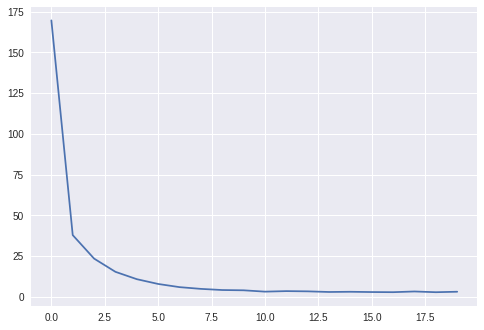

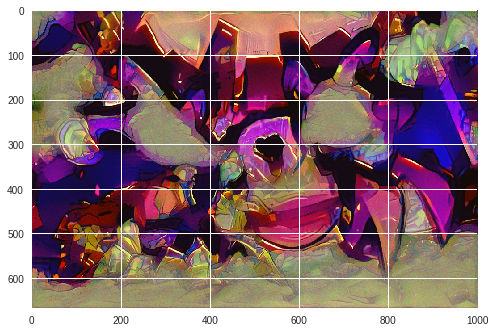

In [30]:
img = image.load_img(style_image_path, target_size = shape)

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

vgg = VGG16_AvgPool(shape)

# selecting conv layers at which we want our outputs
# we had to use layers.get_output_at() instead of layers.output because the layers has multiple inbound nodes
# multiple nodes were created because, remember we replaced all maxpooling layers with averagepooling layers
# to do that we created a new instance of Model, since 2 VGG models exist in memory, it creates two different layers
# and to access a specific one, we need to use the get_output_at() method with an index. Since averagepooling layer model 
# was created second, it's layers get index of 1, while maxpooling layers model's layers will get index 0

symbolic_conv_outputs = [layers.get_output_at(1) for layers in vgg.layers if layers.name.endswith('conv1')]

multi_output_model = Model(vgg.input, symbolic_conv_outputs)

# targets
style_layer_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

# calculate style loss
loss = 0
for symbolic, actual in zip(symbolic_conv_outputs, style_layer_outputs):
  loss += style_loss(symbolic[0], actual[0])
  
grads = K.gradients(loss, multi_output_model.input)

get_loss_and_grads = K.function(inputs = [multi_output_model.input], outputs = [loss]+grads)

def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

final_image = minimize(get_loss_and_grads_wrapper, 20, batch_shape, style_image_path, style_shape)
plt.imshow(scale_img(final_image))
plt.show()

**CODE TO GENERATE STYLED IMAGE OF A CONTENT IMAGE - NEURAL STYLE TRANSFER**

In [0]:
def load_image_and_preprocess(path, shape = None):
  img = image.load_img(path, target_size = shape)
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x = preprocess_input(x)
  
  return x

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(667, 1000, 3)
(667, 1000, 3)
iter = 0 loss = 869.6720581054688
iter = 1 loss = 550.0519409179688
iter = 2 loss = 454.8301696777344
iter = 3 loss = 410.8522644042969
iter = 4 loss = 381.5808410644531
iter = 5 loss = 359.0137023925781
iter = 6 loss = 344.10540771484375
iter = 7 loss = 333.2644348144531
iter = 8 loss = 322.5970764160156
iter = 9 loss = 314.1043701171875
iter = 10 loss = 308.4796447753906
iter = 11 loss = 301.68865966796875
iter = 12 loss = 296.68316650390625
iter = 13 loss = 292.3265686035156
iter = 14 loss = 288.9016418457031
iter = 15 loss = 285.38836669921875
iter = 16 loss = 282.74853515625
iter = 17 loss = 279.8467712402344
iter = 18 loss = 277.66448974609375
iter = 19 loss = 275.3803405761719
iter = 20 loss = 273.62109375
iter = 21 loss = 271.3145751953125
iter = 22 loss = 269.8470458984375
iter = 23 loss = 268.21917724609375
iter = 24 loss = 266.7227783203125
iter = 25 loss = 265.5719299316406
iter = 26 loss = 263.6968688964844
iter = 27 loss = 262.62432861328125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(667, 1000, 3)
(667, 1000, 3)
iter = 0 loss = 869.6720581054688
iter = 1 loss = 550.0519409179688
iter = 2 loss = 454.8301696777344
iter = 3 loss = 410.8522644042969
iter = 4 loss = 381.5808410644531
iter = 5 loss = 359.0137023925781
iter = 6 loss = 344.10540771484375
iter = 7 loss = 333.2644348144531
iter = 8 loss = 322.5970764160156
iter = 9 loss = 314.1043701171875
iter = 10 loss = 308.4796447753906
iter = 11 loss = 301.68865966796875
iter = 12 loss = 296.68316650390625
iter = 13 loss = 292.3265686035156
iter = 14 loss = 288.9016418457031
iter = 15 loss = 285.38836669921875
iter = 16 loss = 282.74853515625
iter = 17 loss = 279.8467712402344
iter = 18 loss = 277.66448974609375
iter = 19 loss = 275.3803405761719
iter = 20 loss = 273.62109375
iter = 21 loss = 271.3145751953125
iter = 22 loss = 269.8470458984375
iter = 23 loss = 268.21917724609375
iter = 24 loss = 266.7227783203125
iter = 25 loss = 265.5719299316406
iter = 26 loss = 263.6968688964844
iter = 27 loss = 262.62432861328125


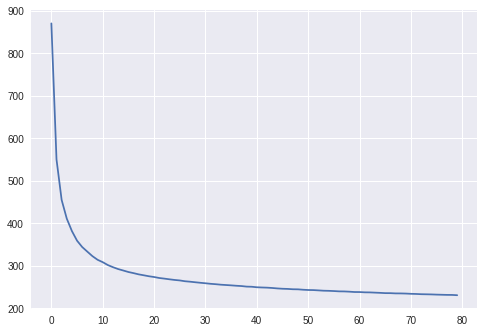

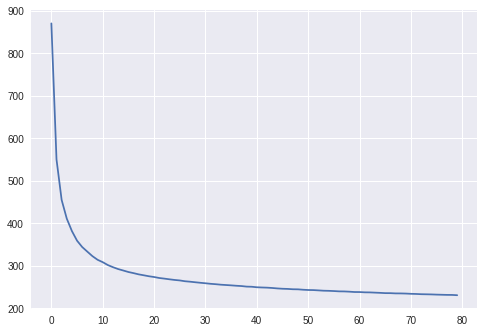

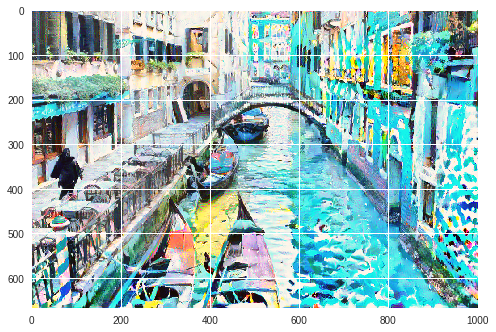

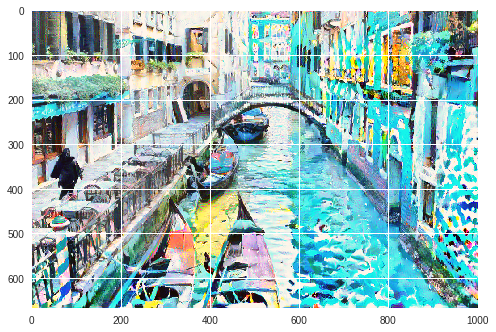

In [20]:
content_img = load_image_and_preprocess(content_image_path)

h, w = content_img.shape[1:3]
style_img = load_image_and_preprocess(style_image_path, shape = (h, w))
batch_shape = content_img.shape
shape = content_img.shape[1:]


vgg = VGG16_AvgPool(shape)

content_model = Model(vgg.input, vgg.layers[13].get_output_at(-1))
content_target = K.variable(content_model.predict(content_img))

symbolic_conv_outputs = [layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')]

style_model = Model(vgg.input, symbolic_conv_outputs)

style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

style_weights = [4, 4, 4, 4, 4]

loss = 3.5*K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  loss += w*style_loss(symbolic[0], actual[0])
  

# It doesn't matter to which model's input we place inside K.grads
# all are pointing to the same input
grads = K.gradients(loss, style_model.input)

get_loss_and_grads = K.function(inputs = [vgg.input], outputs = [loss]+grads)

def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

final_img = minimize(get_loss_and_grads_wrapper, 80, batch_shape, content_image_path, content_shape)
plt.imshow(scale_img(final_img))
plt.show()

scipy.misc.imsave('styled_3.png', scale_img(final_img))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.
